# Non-Visual Motion Planning

This notebook contains code for non-visual motion planning -- the primary objective of the project. The code relies on an LMCP solver, in `lmcp.py`, that takes an LMCP formulation in `M, q, l, u, x_0` and returns a path of points of `z,w,v,t`. A pathsolver in `path.py` then iteratively solves LMCPs for Newton points along an overarching path, performing backward linesearch to progress sufficiently down each of these paths towards the predefined goal point. 

Solving many LMCPs approximates a nonlinear path, which can be formulated as an NMCP for which the KKT conditions must first be derived. In this notebook, the KKT conditions are formulated symbolically so that KKT function as well as the Jacobian of the KKT can be passed to the pathsolver for sparse JIT evaluation, accelerating runtime.

This notebook is exploratory and implements an algorithm for moving a JetBot in a small gridworld, according to the positional / velocity values computed by the pathsolver. 

Findings: 
- With two obstacles, sometimes the pathsolver fails if dt is too small --> dt > 0.1
- Confirmed that the solved states [x,y,vx,vy] closely approximate the dynamics of horizontal motion
- JetBot moves forward 40cm in 0.75 sec at speed=1
- JetBot rotates 360 degrees in 1 sec at speed=1

In [1]:
import numpy as np
from casadi import * 
import matplotlib.pyplot as plt
import time
from math import pi

from path import path_solver

In [2]:
# set forward (True) or backward (False) linesearch in pathsolver
forward = False

# Define a general optimization problem with non-quadratic cost or nonlinear constraints

T = 50 # time points --> 51 coords, including initial
n = 4
m = 2
dt = 0.5 # mult of change per time point

xinit = np.zeros((4,1))
rad = 0.5
obs1 = [2,1.]
obs2 = [0.5,1]
nonlinear_dyn = False
if nonlinear_dyn:
    goal = [-4,5]
else:
    goal = [3,1]

In [3]:
# Simple car dynamics
def f(xt,ut):
    y = []
    if nonlinear_dyn:
        y.append(xt[0]+dt*xt[2]*cos(xt[3]))
        y.append(xt[1]+dt*xt[2]*sin(xt[3]))
        y.append(xt[2]+dt*ut[0])
        y.append(xt[3]+dt*ut[1])
    else:
        y.append(xt[0]+dt*xt[2])
        y.append(xt[1]+dt*xt[3])
        y.append(xt[2]+dt*ut[0])
        y.append(xt[3]+dt*ut[1])
    return y


In [4]:
dynamics = []

U = []
X = []
x0 = MX.sym('x0',n)
X.append(x0)
dynamics.append(x0-xinit)
for t in range(T):
    ut = MX.sym('u%s'%t,m)
    xtt = MX.sym('x%s'%(t+1),n)
    pred = vcat(f(X[-1],ut))
    dynamics.append(xtt-pred)
    U.append(ut)
    X.append(xtt)

In [5]:
cost = 10*((X[-1][0]-goal[0])**2 + (X[-1][1]-goal[1])**2)
for t in range(T):
    cost += (1*U[t][0]**2 + 1*U[t][1]**2)

In [6]:
constraints = []
for t in range(T):
    state = X[t+1]
    if nonlinear_dyn:
        constraints.append(2-state[0])
        constraints.append(state[0]+2)
        constraints.append(2-state[1])
        constraints.append(state[1]+2)
    else:
        const1 = (state[0]-obs1[0])**2 + (state[1]-obs1[1])**2 - rad*rad # square distance from obs should be rad*rad
        const2 = (state[0]-obs2[0])**2 + (state[1]-obs2[1])**2 - rad*rad
        constraints.append(const1)
        constraints.append(const2)

In [7]:
# min_{X,U} cost
#  s.t. dynamics = 0
#       constraints >= 0

# Form KKT conditions

all_dyn = vcat(dynamics)
all_ineq = vcat(constraints)
all_primal_vars = vcat(X+U)


dyn_mults = MX.sym('dyn_mults', all_dyn.shape[0])
ineq_mults = MX.sym('ineq_mults', all_ineq.shape[0])

lag = cost - dot(all_dyn,dyn_mults) - dot(all_ineq,ineq_mults) # grad f - grad g1 - grad g2

dlag = jacobian(lag, all_primal_vars)
kkt_expr = vcat([dlag.T, all_dyn, all_ineq])
all_vars = vcat([all_primal_vars,dyn_mults,ineq_mults])
jac_kkt = jacobian(kkt_expr, all_vars)
eval_kkt = Function('kkt',[all_vars],[kkt_expr])
eval_kkt_jac = Function('kkt',[all_vars],[jac_kkt])

N = all_vars.shape[0]
nprimal = (T+1)*4 + T*2
ndyn = (T+1)*4
nineq = all_ineq.shape[0]

def feval(y):
    return np.array(eval_kkt(y))

def dfeval(y):
    return np.array(eval_kkt_jac(y))

l = np.vstack((-np.inf*np.ones((nprimal+ndyn,1)),np.zeros((nineq,1))))
u = np.inf*np.ones((N,1))

u_start = np.zeros((T*2,1))
if nonlinear_dyn:
    u0 = np.array([0.1,-0.01]).reshape(2,1)
else:
    u0 = np.array([0,1]).reshape(2,1)

x_start = np.zeros(((T+1)*4,1))
x_start[0:4] = xinit
for t in range(T):
    u_start[t*2:(t+1)*2] = u0
    x_start[(t+1)*4:(t+2)*4] = f(x_start[(t)*4:(t+1)*4], u_start[(t)*2:(t+1)*2])

x0 = np.vstack((x_start,u_start,np.zeros(((ndyn+nineq,1)))))

In [8]:
[z,w,v,success] = path_solver(feval, dfeval, l, u, x0=x0, sigma=0.1, max_iters=100, tol=1e-4, forward=forward, linesearch=nonlinear_dyn)
print('Success?', success)
# print("--- %s seconds ---" % (time() - start_time))
traj = z[0:(T+1)*4]

# each z for each time point is split into 4 [x,y,u1,u2] --> get every 4th for vars at each point
px = traj[0::4].reshape(-1,)
py = traj[1::4].reshape(-1,)
pvx = traj[2::4].reshape(-1,)
pvy = traj[3::4].reshape(-1,)

iter 0 52048274977.83203
path len 4
iter 1 2733027552.9150743
path len 5
iter 2 272681703.5614318
path len 30
iter 3 63740173.376527935
path len 38
iter 4 20539857.330470677
path len 75
iter 5 2646340.244514066
path len 32
iter 6 266227.4029232209
path len 58
iter 7 36963.02489330297
path len 18
iter 8 4788.260043673757
path len 60
iter 9 893.2783467308113
path len 10
iter 10 113.04264525179123
path len 34
iter 11 34.35521821917583
path len 5
iter 12 14.584334019899725
path len 34
iter 13 0.7642907395788037
path len 7
iter 14 0.0083109913169516
path len 2
iter 15 1.356154045897297e-06
Success? True


In [9]:
# confirm that each state [x,y,vx,vy] adheres to horizontal motion dynamics
# for i in range(1,len(px)):
#     x = px[i]
#     y = py[i]
#     print(x, px[i-1]+dt*pvx[i-1])
#     print(y, py[i-1]+dt*pvy[i-1])

1. Speed Control (speed_gain_slider): To start your JetBot increase ``speed_gain_slider`` 
2. Steering Gain Control (steering_gain_slider): If you see JetBot is wobbling, you need to reduce ``steering_gain_slider`` till it is smooth
3. Steering Bias control (steering_bias_slider): If you see JetBot is biased towards extreme right or extreme left side of the track, you should control this slider till JetBot start following line or track in the center.  This accounts for motor biases as well as camera offsets

In [10]:
from jetbot_motion import JetBotMotion
from jetbot import Robot

robot = Robot()

motion = JetBotMotion(robot, dt)

FloatSlider(value=0.1, description='speed gain', max=1.0, step=0.01)

FloatSlider(value=0.2, description='steering gain', max=1.0, step=0.01)

FloatSlider(value=0.0, description='steering kd', max=0.5, step=0.001)

FloatSlider(value=0.0, description='steering bias', max=0.3, min=-0.3, step=0.01)

FloatSlider(value=0.0, description='x', max=1.0, min=-1.0)

FloatSlider(value=0.0, description='steering', max=1.0, min=-1.0)

FloatSlider(value=0.1, description='sleep', max=1.0, step=0.001)

In [14]:
time.sleep(5) # for taking videos

motion.Reset()
for x, y, vx, vy in zip(px,py, pvx, pvy): 
#     motion.MoveTo(x, y, vx, vy)
    motion.Manhattan(x,y,vx,vy)

robot.stop()

Moved to  (0.0, 0.0)
Moved to  (-7.517135062566164e-17, 3.2381504884900395e-17)
Moved to  (-0.0029105719283362965, 0.010198891655224166)
Moved to  (-0.008240582461848918, 0.0298964479155627)
Moved to  (-0.015498898277376941, 0.05839244173090468)
Moved to  (-0.024194386051762513, 0.09498664605114174)
Moved to  (-0.03383591246184429, 0.13897883382616347)
Moved to  (-0.04393234418446371, 0.18966877800586016)
Moved to  (-0.053992547896458194, 0.24635625154012164)


KeyboardInterrupt: 

In [15]:
### motion debug

# time.sleep(5)
# robot.stop()

motion.Reset()
motion.MoveTo(1,1,0,0)

# motion.MoveTo(1,0,0,0)
# motion.MoveTo(-1,0,0,0)
# motion.MoveTo(-1,-1,0,0)
# motion.MoveTo(0,1,0,0)

# robot.set_motors(0.4,0.09)
# time.sleep(2)
# robot.stop()

# robot.backward(1)
# time.sleep(1)
# robot.stop()

# robot.left(1)
# time.sleep(1)
# robot.stop()

# motion.TurnRight()
# motion.TurnLeft()
# motion.TurnBy(3.14)

Turned by angle  45.0
Moved to  (1, 1)


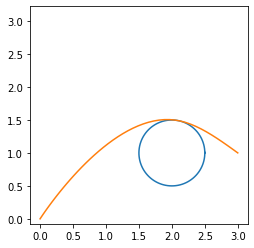

In [25]:
if nonlinear_dyn:
    plt.plot([-2,-2,2,2,-2],[-2,2,2,-2,-2])
else: # plot a circle for obst
    R = np.linspace(0,6.3,100)
    plt.plot(rad*cos(R)+obs1[0],rad*sin(R)+obs1[1])
#     plt.plot(rad * cos(R) + obs2[0], rad * sin(R) + obs2[1])
plt.figure
plt.plot(px,py)
plt.axis([-4,4,-4,4])
plt.axis('square')
plt.show()